# Start

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch

import fraud_detection as fd

datapath = "./data/transformed_label_and_damage.parquet"

In [3]:
import os
os.chdir("..")

In [16]:
df = pd.read_csv("model_metrics_grand_comparison_all.csv")

In [17]:
# make "Unnamed: 0" the index column and drop the name
df = df.set_index("Unnamed: 0")
df.index.name = None
df

,Logistic Regression,Decision Tree,Random Forest,LGBMClassifier,XGBoost simple,CatBoost,NeuralNet
precision_mean,0.7463313682548623,0.7491392889044296,0.7529818785448923,0.8426939300031978,0.8424397188299575,0.8538054331738212,0.816170952821926
precision_max,0.7820823244552058,0.8253424657534246,0.816247582205029,0.8783542039355993,0.8823529411764706,0.8875,0.8615071283095723
precision_min,0.7035490605427975,0.6755725190839694,0.7219662058371735,0.8160291438979964,0.8073555166374781,0.819672131147541,0.7738317757009345
precision_var,0.00046150201294719304,0.000804544668550318,0.0005411338233722045,0.00024037200147300437,0.00031238730948295854,0.00028520798987654883,0.000491356736414074
recall_mean,0.38475815707493033,0.5613382521724872,0.5401599169262721,0.5486229436519648,0.5523631742908673,0.542966825162595,0.508089796141444
recall_max,0.41238317757009346,0.6210526315789474,0.6004672897196262,0.591812865497076,0.5789473684210527,0.5883040935672514,0.5309941520467836
recall_min,0.36140350877192984,0.5093457943925234,0.46845794392523366,0.5210280373831776,0.522196261682243,0.514018691588785,0.47313084112149534
recall_var,0.00015510752324669226,0.0005208342045810721,0.0009257558778332676,0.0003282819259605636,0.00027212176348811616,0.00030310439633544754,0.0002734352263159018
f1_mean,0.5075676643754587,0.6411858428636479,0.6280896624389085,0.6643835172315278,0.667068730820469,0.6636221666858533,0.6260188912254143
f1_max,0.5356600910470409,0.6769436997319035,0.6609836065573771,0.6944837340876945,0.6991525423728814,0.7024734982332156,0.6493506493506493


In [ ]:
cms = df.index[df.index.str.contains("cm")].tolist()

In [53]:
# remove row with index cm
df = df.drop(cms, axis=0)

In [54]:
df = df.astype(float)

In [22]:
cat = "precision"

df_prec = df[df.index.str.contains("|".join(cat + "_" + m for m in ["mean", "max", "min", "var"]))]
df_prec = df_prec.astype(float)

In [78]:
df_prec_mean = df_prec[df_prec.index.str.contains("mean")]
df_prec_max = df_prec[df_prec.index.str.contains("max")]
df_prec_min = df_prec[df_prec.index.str.contains("min")]
df_prec_var = df_prec[df_prec.index.str.contains("var")]
df_prec_std = df_prec_var.apply(np.sqrt)
# Calculate asymmetric errors: mean - min (lower), max - mean (upper)
lower_errors =df_prec_mean.iloc[0,:] - df_prec_min.iloc[0,:]
upper_errors = df_prec_max.iloc[0,:] - df_prec_mean.iloc[0,:]
asymmetric_error = np.array([lower_errors.values, upper_errors.values])

df_rec_mean = df[df.index.str.contains("recall_mean")]
df_rec_max = df[df.index.str.contains("recall_max")]
df_rec_min = df[df.index.str.contains("recall_min")]
df_rec_var = df[df.index.str.contains("recall_var")]
df_rec_std = df_rec_var.apply(np.sqrt)
# Calculate asymmetric errors: mean - min (lower), max - mean (upper)
lower_errors_rec = df_rec_mean.iloc[0,:] - df_rec_min.iloc[0,:]
upper_errors_rec = df_rec_max.iloc[0,:] - df_rec_mean.iloc[0,:]
asymmetric_error_rec = np.array([lower_errors_rec.values, upper_errors_rec.values])

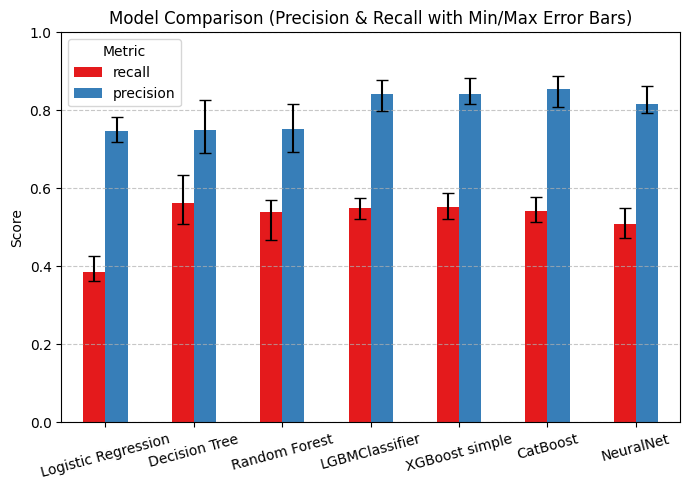

In [80]:
# Combine mean values into a single DataFrame
combined_means = pd.DataFrame({
    'recall': df_rec_mean.iloc[0],
    'precision': df_prec_mean.iloc[0],
})

# Combine asymmetric errors
combined_errors = np.array([
    [lower_errors_rec.values, lower_errors.values],   # lower
    [upper_errors_rec.values, upper_errors.values]    # upper
])

# Transpose error arrays to match bar positions
asymmetric_error_combined = np.transpose(combined_errors, (1, 0, 2))

# Extract lower and upper errors in correct format
lower_errs = np.vstack((lower_errors_rec.values, lower_errors.values))
upper_errs = np.vstack((upper_errors_rec.values, upper_errors.values))
asymmetric_error = [lower_errs, upper_errs]

# Plot with grouped bars
ax = combined_means.plot(kind='bar', yerr=asymmetric_error, capsize=4, figsize=(7,5))

# set nicer colors (sns)
sns.set_palette("Accent")
# other palettes: "Set2", "Set3", "Dark2", "Paired", "Accent"
ax.set_ylabel("Score")
ax.set_title("Model Comparison (Precision & Recall with Min/Max Error Bars)")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
ax = mean_pivot.plot(kind='bar', yerr=std_pivot, capsize=4, figsize=(8,6))
ax.set_ylabel("Score")
ax.set_title("Model Comparison on Metrics (mean ± std)")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

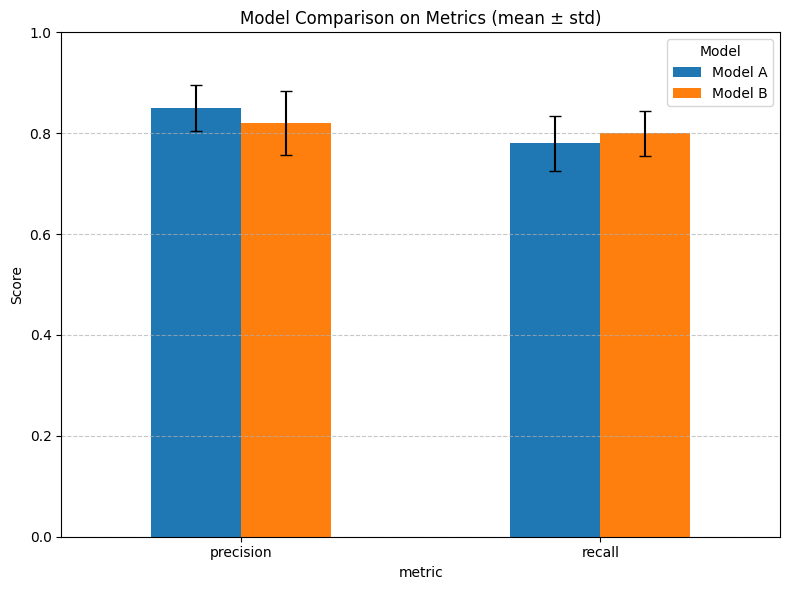

In [14]:

# Example data
data = {
    'model': ['Model A', 'Model A', 'Model B', 'Model B'],
    'metric': ['precision', 'recall', 'precision', 'recall'],
    'mean': [0.85, 0.78, 0.82, 0.80],
    'min': [0.80, 0.70, 0.75, 0.72],
    'max': [0.90, 0.85, 0.88, 0.87],
    'var': [0.002, 0.003, 0.004, 0.002]
}

df = pd.DataFrame(data)

# Calculate standard deviation from variance
df['std'] = np.sqrt(df['var'])

# Pivot to wide format for plotting grouped bars
mean_pivot = df.pivot(index='metric', columns='model', values='mean')
std_pivot = df.pivot(index='metric', columns='model', values='std')

# Plot
ax = mean_pivot.plot(kind='bar', yerr=std_pivot, capsize=4, figsize=(8,6))
ax.set_ylabel("Score")
ax.set_title("Model Comparison on Metrics (mean ± std)")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [65]:
mean_vals = model_metrics[model_metrics.index.str.contains("mean")].T
mean_cols = list(map(lambda x: x.replace("_mean", "").replace(":", ""), mean_vals.columns.to_list()))
mean_vals.columns = mean_cols
# change dtype to float
mean_vals = mean_vals.astype(float)
mean_vals = mean_vals.round(3)
mean_vals[["precision", "recall", "f1", "auc-pr", "damage_prevented", "Bewertung"]]

,precision,recall,f1,auc-pr,damage_prevented,Bewertung
Logistic Regression,0.746,0.385,0.508,0.431,2219.208,-3271.956
Decision Tree,0.749,0.561,0.641,0.655,3648.474,-1585.290
Random Forest,0.753,0.540,0.628,0.681,3484.541,-1748.223
LGBMClassifier,0.843,0.549,0.664,0.729,3524.914,-1020.850
XGBoost simple,0.842,0.552,0.667,0.730,3555.049,-982.715
CatBoost,0.854,0.543,0.664,0.733,3510.251,-978.913
NeuralNet,0.816,0.508,0.626,0.681,3356.139,-1468.625


In [78]:
cm = model_metrics[model_metrics.index.str.contains("cm")].T
cm["TP"] = cm["cm"].apply(lambda x: x[1, 1])
cm["FP"] = cm["cm"].apply(lambda x: x[0, 1])
cm["FN"] = cm["cm"].apply(lambda x: x[1, 0])
cm["TN"] = cm["cm"].apply(lambda x: x[0, 0])
cm.drop(columns=["cm"], inplace=True)
cm

,TP,FP,FN,TN
Logistic Regression,329.20,112.20,526.40,28561.60
Decision Tree,480.28,162.00,375.32,28511.80
Random Forest,462.16,152.84,393.44,28520.96
LGBMClassifier,469.40,87.76,386.20,28586.04
XGBoost simple,472.60,88.56,383.00,28585.24
CatBoost,464.56,79.68,391.04,28594.12
NeuralNet,434.72,98.32,420.88,28575.48


Das neuronale Netzwerk ist nocht recht unstabil und erzielt nicht immer gute Ergebnisse (in diesem Durchlauf schnitt es aber am besten ab).